# Predicting pull request merges

In this example, we will attempt to predict whether a pull request will be merged. The dataset we will be using is a newer version of the one published at MSR 2014 by [Gousios and Zaidman](http://gousios.org/bibliography/GZ14.html),
available [here](https://drive.google.com/open?id=0B9Rx0uhucsroV196OEp5VGhzSkU). The dataset comes in CSV format.

For this task, we will be using PySpark and the Spark ML library, to demonstrate
how nicely Spark integrates with the extremely rich Python Data Science/Big Data ecosystem.

We begin our exploration by importing typical libraries from the Python world:

* [Pandas](https://pandas.pydata.org) Implements data frame functionality, which enables us to manipulate data in a tabular format using our well-trusted higher-order functions.
* [MatPlotLib](https://matplotlib.org) Implements programmatic plotting functionality, acts as the backend for all graphics utilities in Python 
* [GGPlot](http://ggplot.yhathq.com) A principled way for creating statistical plots, based on the [Grammar for Graphics](http://www.springer.com/gp/book/9780387245447)

In [18]:
from ggplot import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from copy import deepcopy

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In contrast to our previous examples, we will be using higher level components; one of them is the Spark CSV reader. This allows us to read a CSV file into a Spark Dataframe in one line; most importantly, it can automatically infer the schema (data types) from our CSV, which saves us lots of boring work! 

In [2]:
df = sqlContext.read.csv("dataset_v2.csv", 
                         sep=",", 
                         header=True, 
                         inferSchema=True).cache()
aux = df.toPandas()
names = []
for i, row in aux.groupby('project_name').size().iteritems():
    if row > 50:
        names.append(i)
        
aux = aux.loc[aux['project_name'].isin(names)]
aux['mergetime_minutes'] = aux['mergetime_minutes'].fillna(0.0);
aux['merged'] = aux['mergetime_minutes'].where(aux['mergetime_minutes'].isnull() | aux['mergetime_minutes'] == 0.0, True).fillna(False).astype(bool)
df = sqlContext.createDataFrame(aux)
sqlContext.registerDataFrameAsTable(df, "pullreqs")

## Exploring the dataset

We are also using Spark's `SQLContext` instead of our typical `SparkContext`. This allows us to run SQL queries directly on top our CSV data! Spark will in the background distribute the processing load on all workers. 

PySpark is integrated to the [Pydata](http://pydata.org) ecosystem; this allows us to use the `toPandas()` function,
which will convert a distributed Spark DataFrame to a local Pandas dataframe. The are many legitimate reasons for
which this is a good thing: we can for example use the data for plotting or apply some [sckit-learn](http://scikit-learn.org/) machine learning algorith on top of it. In our case, we exploit the fact that Jupyter, our notebook system, knows about Pandas dataframes to print the results locally.

#### What are the columns in our CSV file?

In [20]:
df.printSchema()
# df.groupBy('project_name').count().toPandas()
# df.select('mergetime_minutes').where('mergetime_minutes is null').toPandas()

root
 |-- pull_req_id: long (nullable = true)
 |-- project_name: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- github_id: long (nullable = true)
 |-- created_at: long (nullable = true)
 |-- merged_at: double (nullable = true)
 |-- closed_at: long (nullable = true)
 |-- lifetime_minutes: long (nullable = true)
 |-- mergetime_minutes: double (nullable = true)
 |-- merged_using: string (nullable = true)
 |-- conflict: boolean (nullable = true)
 |-- forward_links: boolean (nullable = true)
 |-- intra_branch: boolean (nullable = true)
 |-- description_length: long (nullable = true)
 |-- num_commits: long (nullable = true)
 |-- num_commits_open: long (nullable = true)
 |-- num_pr_comments: long (nullable = true)
 |-- num_issue_comments: long (nullable = true)
 |-- num_commit_comments: long (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- num_commit_comments_open: long (nullable = true)
 |-- num_participants: long (nullable = true)
 |-- files_added_open: lo

In [25]:
sqlContext.sql("""select merged_using, count(*) as occurences 
                  from pullreqs 
                  group by merged_using 
                  order by occurences desc""").show()

+--------------------+----------+
|        merged_using|occurences|
+--------------------+----------+
|        merge_button|      7883|
|   commits_in_master|      7109|
|             unknown|       335|
|  merged_in_comments|        23|
|commit_sha_in_com...|        19|
|     fixes_in_commit|         8|
+--------------------+----------+



The above SQL query can be also defined programmatically. At the background, Spark is compiling SQL to a series of calls like the ones we show below.

In [42]:
df.\
    groupBy(df.merged_using).\
    agg({'merged_using': 'count'}).\
    orderBy(desc("count(merged_using)")).\
    show()

+--------------------+-------------------+
|        merged_using|count(merged_using)|
+--------------------+-------------------+
|        merge_button|             182424|
|   commits_in_master|             105378|
|             unknown|               7318|
|commit_sha_in_com...|               1128|
|  merged_in_comments|                307|
|     fixes_in_commit|                 39|
+--------------------+-------------------+



#### How many projects and languages are there?

In [7]:
sqlContext.sql("""select count(distinct(project_name)) as num_projects 
                  from pullreqs""").show()

+------------+
|num_projects|
+------------+
|         749|
+------------+



Ok, but how many projects are there per programming language? Let's do a quick SQL query:

In [6]:
sqlContext.sql("""select lang, count(*) as num_projects 
                  from (
                      select distinct(project_name), lang 
                      from pullreqs
                  ) as project_langs
                  group by lang
                  order by num_projects desc""").show()

+----------+------------+
|      lang|num_projects|
+----------+------------+
|JavaScript|         255|
|    Python|         192|
|      Java|         159|
|      Ruby|         128|
|     Scala|          15|
+----------+------------+



We can do exactly the same query using Dataframe transformations:

In [24]:
df.select(df["project_name"], df["lang"]).\
    distinct().\
    groupBy(df["lang"]).\
    agg({"lang":"count"}).\
    orderBy("count(lang)", ascending=False).\
    show()

+----------+-----------+
|      lang|count(lang)|
+----------+-----------+
|      Java|         41|
|    Python|         25|
|      Ruby|         12|
|JavaScript|          2|
+----------+-----------+



#### Time to close pull requests (external contributors) - box

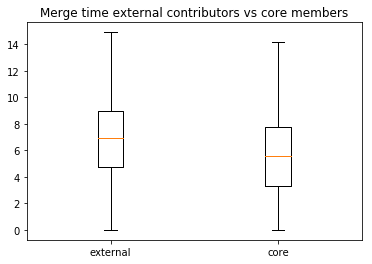

In [24]:
ax = df.select('mergetime_minutes').\
    where('mergetime_minutes > 0.0 and main_team_member = false').\
    toPandas().\
    apply(np.log)
    
ax2 = df.select('mergetime_minutes').\
    where('mergetime_minutes > 0.0 and main_team_member = true').\
    toPandas().\
    apply(np.log)


plt.boxplot([ax, ax2])
plt.xticks([1, 2], ['external', 'core'])
plt.title('Merge time external contributors vs core members')

plt.savefig('box.png', dpi=400)
    

#### What is the PR distribution per project?

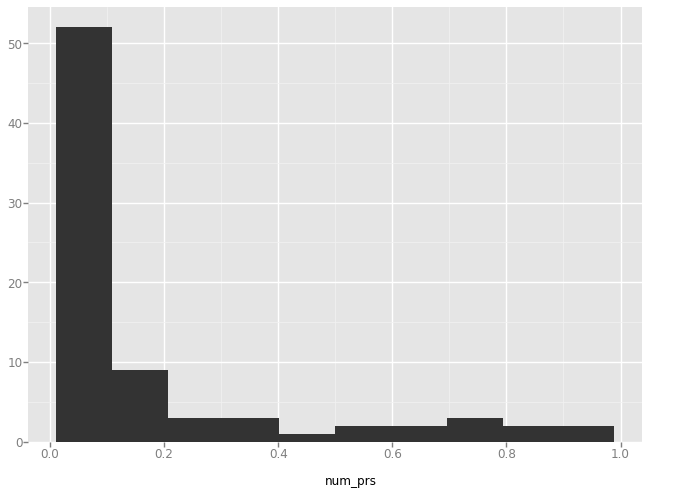

<ggplot: (287474357)>

In [26]:
r = sqlContext.sql("""select project_name, count(*) as num_prs
                  from pullreqs
                  group by project_name having num_prs < 1000""").toPandas()
r['num_prs'] = r['num_prs'] / 1000;
r

ggplot(aes(x='num_prs'), data = r) + geom_histogram(binwidth = .01)
# ggplot(aes(x = 'num_prs'), data=r) + \
#     geom_histogram(binwidth=.001) + \
#     scale_x_log() + \
#     ylab("Num projects") + xlab("Num PRs")

#### How much time does it take to close a PR?

As we can see, the majority (75%) of all pull requests are closed in less than 2 days, while 50% are closed in just 6 hours.

In [3]:
df.select('mergetime_minutes').where('mergetime_minutes > 0.0').toPandas().apply(lambda x: x / 1440).describe(percentiles=[0.6, 0.74, 0.8, 0.9, 0.95])

,mergetime_minutes
count,13136.000000
mean,5.744971
std,24.975450
min,0.000694
50%,0.619792
60%,0.921528
74%,2.739444
80%,4.048611
90%,11.204861
95%,22.791146


#### Main team members

In [4]:
df.select('mergetime_minutes').\
    where('mergetime_minutes > 0.0 and main_team_member = true').\
    toPandas().apply(lambda x: x / 1440).\
    describe(percentiles=[0.6, 0.74, 0.8, 0.9, 0.95])

,mergetime_minutes
count,11572.000000
mean,4.347929
std,17.160871
min,0.000694
50%,0.547222
60%,0.872222
74%,2.255931
80%,3.807639
90%,9.061181
95%,18.607049


#### Not main team members

In [5]:
df.select('mergetime_minutes').\
    where('mergetime_minutes > 0.0 and main_team_member = false').\
    toPandas().apply(lambda x: x / 1440).\
    describe(percentiles=[0.6, 0.74, 0.8, 0.9, 0.95])

,mergetime_minutes
count,1564.000000
mean,16.081655
std,54.226121
min,0.000694
50%,1.057986
60%,2.130139
74%,6.796431
80%,11.614167
90%,32.137361
95%,79.802569


#### Close time for unmerged pull requests

In [6]:
df.select('lifetime_minutes').\
    where('mergetime_minutes = 0.0 and lifetime_minutes > 0.0').\
    toPandas().\
    apply(lambda x: x / 1440).\
    describe()

,lifetime_minutes
count,361.000000
mean,11.248848
std,44.049190
min,0.000694
25%,0.050000
50%,0.719444
75%,4.987500
max,547.624306


### Size of pull requests
#### Number of commits

In [8]:
df.select('num_commits').\
    toPandas().\
    describe(percentiles=[0.8, 0.9, 0.95])

,num_commits
count,15377.000000
mean,4.264421
std,13.398812
min,1.000000
50%,2.000000
80%,4.000000
90%,8.000000
95%,13.000000
max,258.000000


#### Files changed

In [9]:
df.select('files_changed').\
    toPandas().\
    describe(percentiles=[0.8, 0.9, 0.95])

,files_changed
count,15377.000000
mean,14.424725
std,56.785824
min,0.000000
50%,3.000000
80%,12.000000
90%,26.000000
95%,52.000000
max,2687.000000


#### Number of changed lines

In [10]:
df.select('src_churn').\
    where('src_churn > 0.0').\
    toPandas().\
    describe(percentiles=[0.8, 0.9, 0.95])

,src_churn
count,290.000000
mean,42.493103
std,92.717275
min,1.000000
50%,11.000000
80%,48.400000
90%,113.500000
95%,192.950000
max,842.000000


### Discussion and code review
#### Comments

In [12]:
df.select('num_comments').\
    toPandas().\
    describe(percentiles=[0.8, 0.9, 0.95])

,num_comments
count,15377.000000
mean,2.936073
std,7.941817
min,0.000000
50%,1.000000
80%,4.000000
90%,7.000000
95%,12.000000
max,240.000000


#### Correlation between size and merge decision

In [13]:
print 'Num Commits: ' + str(aux['num_commits'].corr(aux['merged'], method='spearman'))
print 'Files changed: ' + str(aux['src_files'].corr(aux['merged'], method='spearman'))
print 'Lines changed: ' + str(aux['src_churn'].corr(aux['merged'], method='spearman'))
# aux['num_commits'].corr(aux['merged'], method='spearman')

Num Commits: 0.167528442551
Files changed: 0.00724571354084
Lines changed: 0.00828534249669


#### Correlation between number of comments and pull request

In [30]:
print 'Merge decision: ' + str(aux['num_comments'].corr(aux['merged'], method='spearman'))
print 'Merge time: ' + str(aux['num_comments'].corr(aux['mergetime_minutes'], method='spearman'))

Merge decision: 0.335960922278
Merge time: 0.523524975596


#### How many people work on PRs?

Not many

In [10]:
df.select('num_participants').toPandas().describe()

,num_participants
count,290386.000000
mean,1.032302
std,1.312486
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,50.000000


#### How many comments do PRs receive?

A few

In [11]:
df.select('num_comments').toPandas().describe()

,num_comments
count,290386.000000
mean,2.410030
std,6.652631
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,475.000000


#### How balanced is the dataset? 

It is important for our machine learning task to check whether 

In [35]:
df.groupBy('merged').count().toPandas()

,merged,count
0,True,13136
1,False,2241


## Predicting pull request merges

We are trying to create a predictor that given a set of _features_ (metrics about various aspects of a single PR), it will come up with a _response_ (prediction): either **True** (PR will be merged) or **False** (PR will not be merged). Our predictor is a typical binary classification task.

There are various algorithms that given a set of _feature vectors_ (vectors/arrays of numerical values that correspond to our features) they will come up with a _model_ to predict an outcome. The ones we will be using are:

* [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression)
* [Linear Support Vector Machines](https://en.wikipedia.org/wiki/Support_vector_machine)
* [Decision trees](https://en.wikipedia.org/wiki/Decision_tree)
* [Random Forests](https://en.wikipedia.org/wiki/Random_forest)
* [Gradient Boosting Machines](https://en.wikipedia.org/wiki/Gradient_boosting)

The first step in any binary classification task is to define the features and the response variable:

In [4]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

In [5]:
def label_time (row):
    minutes = row['mergetime_minutes']
    if minutes < 24 * 60:
        return 0
    return 1

In [6]:
aux0 = deepcopy(aux)

correlation(aux0, 0.7)

# print aux2.columns
feature_cols = []
for i in range(3, len(aux0.columns)):
    if aux0.columns[i] != 'merged' and aux0.columns[i].find("minute") == -1 and aux0.columns[i] != 'first_response':
        if aux0[aux0.columns[i]].dtype != 'object':
            feature_cols.append(aux0.columns[i])

# feature_cols = ['prior_interaction_pr_events', 'team_size', 'num_participants', 'num_issue_comments']


response = 'merged'
aux1 = aux.sample(15200);
aux2 = aux.sample(15200);
aux2['mergetime_minutes'] = aux2['mergetime_minutes'].astype(int)
aux2['mergetime'] = aux2.apply(lambda row: label_time(row), axis = 1)

df1 = sqlContext.createDataFrame(aux1);
df2 = sqlContext.createDataFrame(aux2);

# We drop any possible duplicates and cache the resulting data frame
data = df1.select(feature_cols).dropDuplicates().cache()



Most machine learning algorithm implementations work with numerical vectors. For this reason, we need to convert all features that are not of type `Integer` in our source data frame to numeric. Fortunately, we only have a few `Boolean` features that can be represeted as `Integer`s by assigning 1 to True values and 0 to False with a simple type cast. If we had factors (those take values from a predefined set) as features, we would need to use a `StringIndexer` on them.

SparkML needs all features to be in a single vector per data point. For this, we use the `VectorAssember` transformation.

SparkML makes use of pipelines to organize the application of transformations on data frames. In our case, we only need to build a pipeline that performs the `VectorAssember` step, but those pipelines can be arbitrarily large.

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# All boolean columns
boolean = ['intra_branch', 'main_team_member', 
           'social_connection', 'conflict', 'forward_links']
boolean_out = map(lambda x: x + "_int", boolean)

# Update the feature_cols with information about the new column names
feature_cols = [item for item in set(feature_cols) \
                if item not in set(boolean)] + \
                boolean_out

# Type cast boolean columns to Integers (convert to numeric)
for x in boolean:
    df1 = df1.withColumn(x + "_int", df1[x].cast(IntegerType()))
    df2 = df2.withColumn(x + "_int", df2[x].cast(IntegerType()))
df1 = df1.withColumn("merged_int", df1['merged'].cast(IntegerType()))
df2 = df2.withColumn("merged_int", df2['merged'].cast(IntegerType()))

# Convert feature columns to a numeric vector
assembler_features = VectorAssembler(inputCols=feature_cols, 
                                     outputCol='features')

# Construct and execute a pipeline, cache the results.
pipeline = Pipeline(stages=[assembler_features])
allData = pipeline.fit(df1).transform(df1).cache()

After we have our data in the desirable format, we can start experimenting with machine learning algorithms. For that, we need to have 2 datasets: one to apply our algorithm on and one to test the resulting model with.

In [8]:
(trainingData, testData) = allData.randomSplit([0.9, 0.1], seed=42)

print trainingData.count()

13704


The process of running an ML algorithm on a dataset consists of the following steps:

1. Train a model
2. Apply the trained model on the test set, collect performance metrics
3. Tune the ML algorithm and repeat

To evaluate the training (step 2), and since we are using binary classification, we need to test how well our model can predict against a ground truth included in the test set. The result of step 2 is the so called [_confusion matrix_](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix looks like this:

|              |       |Ground truth |
|--------------|-------|-------------|
|              |       | True | False|
| *Prediction* | True  | *TP* | *FP* | 
|              | False | *FN* | *TN* |


Using this table we can come up with many metrics that capture several aspects of the classification performance, such as:

$$ Precision = \frac{TP}{TP + FP} $$

$$ Recall = \frac{TP}{TP + FN} $$

$$ Accuracy = \frac{TP + TN}{TP + FP + FN + TN} $$

$$ False\ positive\ rate = \frac{FP}{FP + TN} $$

When predicting, most binary classification algorithms return the *probability* that a result is either true or false, rather than the actual result; depending on how strong our prediction requirements are, we need to vary the *threshold* after which we start believing a prediction. This threshold is usually set at 0.7, so if our classifier reports a probability of 0.73 for a classification result being True, we take its value as True.

By varying this threshold from 0.5 to 1, we can see how strong our classifier believes its results are; we can then test them against reality (our ground truth) to see how strong they _actually_ are. To do so, we plot the classifier's recall (or True Positive Rate) against its False Positive Rate for various values of threshold. This will result in a plot (called the [Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve) that looks like the following:

![A ROC curve](roccurves.png)

The area under each curve can be calculated; this results in a composite metric (Area Under the (ROC) Curve) that describes the predictive power of our classifier against a random classifier. AUC enables comparisons of classifiers with each other and is especially useful as a metric in case of unbalanced datasets, as in our case.

For our purposes, we will be using the AUC metric.

In [10]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Calculate and return the AUC metric
def evaluate(testData, predictions):
    evaluator = BinaryClassificationEvaluator(labelCol="merged_int", 
                                              rawPredictionCol="rawPrediction")
    print "AUC: %f" % evaluator.evaluate(predictions)

## Merge decision

### Logistic regression

As with other regressions, binary logistic regression does polynomial fiting: it attempts to compute the co-efficients $a$ and $b$ and the intercept $c$ of a polynomial of the form $y = ax_1 + bx_2+ c$, where $x_1, x_2$ and $y$ come from the training data, in order to maximize a training criterion (the workings under the hood are very different though). 

With default settings, it does a terrible job on our dataset, with an AUC of 0.5.

In [20]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10, regParam=0.3, 
                        elasticNetParam=0.8 ,labelCol="merged_int")

lrModel = lr.fit(trainingData)
evaluate(testData, lrModel.transform(testData))

AUC: 0.500000


### Linear Support Vector Machine

SVMs attempt to partition datasets using hyperplanes in a way that dataset points are as far as possible in high-dimentional spaces.

In [21]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter=10, regParam=0.1,labelCol="merged_int")

lsvcModel = lsvc.fit(trainingData)
evaluate(testData, lsvcModel.transform(testData))

AUC: 0.807587


### Decision tree

A decision (classification) tree is a tree structure where intermediate nodes represent a decision that partitions the data while leafs represent a classification class. Decision trees are easy to train and very intuitive to interpret, as they mimic human decision making. Unfortunately though they tend to overfit (especially if we allow them to grow to very big depths) and not robust against data variation.

On our dataset, they perform rather well.

In [22]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="merged_int")

dtModel = dt.fit(trainingData)
evaluate(testData, dtModel.transform(testData))

AUC: 0.836371


### Random Forests

Random forests work by building many decision trees. For buildingeach tree, a (configurable) number of features is selected randomly, while the trees are grown up to a (configurable) depth. Then, at prediction time, all trees are asked about their "opinion" on the input feature values, and the majority vote wins.

RF are a very easy algorithm to train and default values usually lead to good perfomance out of the box.

In [26]:
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf = RF(labelCol='merged_int', featuresCol='features', 
        numTrees=100, maxDepth=5)
rfModel = rf.fit(trainingData)
evaluate(testData, rfModel.transform(testData))

AUC: 0.908029


One particularly interesting property of tree ensemble methods, such as random forests, is that they provide us with an indication of which factors are most influential whed doing a classification. 

In [25]:
pd.DataFrame(data=zip(feature_cols, rfModel.featureImportances), 
             columns=("feature", "importance")).\
            sort_values("importance", ascending=False).\
            head(n = 10)

,feature,importance
34,prior_interaction_pr_events,0.162591
26,num_participants,0.151652
36,num_issue_comments,0.104620
16,stars,0.096960
9,prior_interaction_issue_events,0.052479
20,prior_interaction_issue_comments,0.047444
22,prior_interaction_pr_comments,0.044977
10,test_lines,0.039904
6,description_length,0.037093
37,prior_interaction_commits,0.033226


### Gradient boosting

Boosting refers to a general class of algorithms that try create strong predictors using ensembles of weak ones (e.g. decision trees). After training a weak classifier, boosting algorithms will weight training examples in a way that will favour those that were misclassifed by the current ensemble. Thus, new weak classifiers will be using more training data that were misclassified.

Gradient boosting is a form of boosting that uses [gradient decent](https://en.wikipedia.org/wiki/Gradient_boosting) as an optimization method and stopping criterium.

In [73]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10, maxDepth=5, 
                    labelCol="merged_int", seed=42)
gbtModel = gbt.fit(trainingData)
evaluate(testData, gbtModel.transform(testData))

AUC: 0.862469


In [56]:
pd.DataFrame(data=zip(feature_cols, gbtModel.featureImportances), 
             columns=("feature", "importance")).\
            sort_values("importance", ascending=False).\
            head(n = 10)

,feature,importance
33,prior_interaction_pr_events,0.155641
5,description_length,0.095948
0,team_size,0.087230
25,num_participants,0.069822
38,social_connection_int,0.062853
35,num_issue_comments,0.058130
9,test_lines,0.052535
15,stars,0.043957
24,workload,0.040380
37,main_team_member_int,0.040031


## Merge time

In [38]:
data = df2.select(feature_cols).dropDuplicates().cache()
pipeline = Pipeline(stages=[assembler_features])
allData = pipeline.fit(df2).transform(df2).cache()
(trainingData, testData) = allData.randomSplit([0.9, 0.1], seed=42)

print allData.count()

15200


In [26]:
print feature_cols

['team_size', 'test_churn_open', 'requester_succ_rate', 'num_commit_comments_open', 'files_modified_open', 'files_deleted', 'new_entropy', 'description_length', 'commits_on_files_touched', 'perc_external_contribs', 'prior_interaction_issue_events', 'test_lines', 'num_comments', 'at_mentions_description', 'doc_files_open', 'files_deleted_open', 'prior_interaction_commit_comments', 'followers', 'stars', 'sloc', 'num_pr_comments', 'test_cases', 'files_changed_open', 'num_issue_comments', 'prior_interaction_issue_comments', 'other_files_open', 'github_id', 'prior_interaction_pr_comments', 'prev_pullreqs', 'tests_deleted_open', 'workload', 'num_participants', 'files_added_open', 'num_commits', 'entropy_diff', 'hotness', 'src_files_open', 'at_mentions_comments', 'test_churn', 'num_commit_comments', 'asserts', 'prior_interaction_pr_events', 'src_churn_open', 'tests_added_open', 'prior_interaction_commits', 'intra_branch_int', 'main_team_member_int', 'social_connection_int', 'conflict_int', 'f

### Logistic Regression

In [39]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10, regParam=0.3, 
                        elasticNetParam=0.8 ,labelCol="mergetime")

lrModel = lr.fit(trainingData)
evaluate(testData, lrModel.transform(testData))

AUC: 0.500000


### Linear Support Vector Machines

In [40]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter=10, regParam=0.1,labelCol="mergetime")

lsvcModel = lsvc.fit(trainingData)
evaluate(testData, lsvcModel.transform(testData))

AUC: 0.825126


### Decision tree

In [34]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="mergetime")

dtModel = dt.fit(trainingData)
evaluate(testData, dtModel.transform(testData))

AUC: 0.688113


### Random forests

In [41]:
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf = RF(labelCol='mergetime', featuresCol='features', 
        numTrees=100, maxDepth=5)
rfModel = rf.fit(trainingData)
evaluate(testData, rfModel.transform(testData))

AUC: 0.855543


In [42]:
pd.DataFrame(data=zip(feature_cols, rfModel.featureImportances), 
             columns=("feature", "importance")).\
            sort_values("importance", ascending=False).\
            head(n = 10)

,feature,importance
36,num_issue_comments,0.198043
26,num_participants,0.193517
18,num_pr_comments,0.119250
32,at_mentions_comments,0.082843
25,workload,0.074615
28,num_commits,0.047576
24,tests_deleted_open,0.024480
34,prior_interaction_pr_events,0.023554
2,requester_succ_rate,0.022734
6,description_length,0.022336


## Optimising hyper parameters

As we have seen already, most algorithms contain many knobs (configuration parameters) that we can use to tune the model building. Those are often called _hyper parameters_. To tune them in a systematic manner, Spark ML offers a tool called `Grid` that accepts value ranges for all hyper parameters.

For algorithms that are not robust against overfitting (building a model that predicts very well the training set but fails to generalize), for example decision trees, it is often advisable to train it on various instances of the training set and report average precision/recall/F1/AUC scores. This process is called _cross-validation_. In typical random selection $k$-fold cross validation, the algorith will randomly sample the dataset $k$ times (usually 80%/20% for training and evaluation data), build a model and evaluate it on the remaining training data. Cross validation can also be used as a guard against overfiting when trying to find the optimal model when doing hyper-parameter optimization.

In the following snippet we attempt to improve our decision tree model by tuning several parameters. As we can see, the defaults are pretty ok as we only achieve marginal improvement.

In [32]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [4, 8])
             .addGrid(dt.maxBins, [16, 32, 64])
             .addGrid(dt.minInstancesPerNode, [1, 2],)
             .build())

evaluator = BinaryClassificationEvaluator(labelCol="merged_int",
                                          rawPredictionCol="rawPrediction")
cv = CrossValidator(estimator=dt, 
                    estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=3)
cvModel = cv.fit(trainingData)

In [33]:
evaluate(testData, cvModel.transform(testData))

AUC: 0.791859


In [34]:
cvModel.bestModel

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4371ae808e87c17e3c9b) of depth 8 with 169 nodes

## Improving prediction of minority case

The AUC metric, while comprehensive, tells us half the truth about the prediction performance. As we can see below, the best algorithm (GBT) consistently mispredicts the `merged = False` case, even though it does a good job with the `True` case. This probably happens because the classifier overfits to the majority case (`merged = True` in our case).

In [30]:
def missprediction_rate(model, testData):
    predictions = model.transform(testData)
    predictions = predictions.\
        select(predictions.merged_int.cast("double").alias('ground_truth'), \
               'prediction')

    true_predictions = predictions.\
                       where(predictions.ground_truth == 1.0).\
                       count()
    false_predictions = predictions.\
                        where(predictions.ground_truth == 0.0).\
                        count()
    true_misspredictions = predictions.\
                          where(predictions.ground_truth != predictions.prediction).\
                          where(predictions.ground_truth == 1.0).\
                          count()
    false_misspredictions = predictions.\
                            where(predictions.ground_truth != predictions.prediction).\
                            where(predictions.ground_truth == 0.0).\
                            count()

    return ((float(false_misspredictions) / false_predictions) * 100),\
        ((float(true_misspredictions) / true_predictions) * 100)

print "SVM missprediction rate: False: %f, True: %f" % \
        missprediction_rate(lsvcModel, testData)
print "RF missprediction rate: False: %f, True: %f" % \
        missprediction_rate(rfModel, testData)
print "GBT missprediction rate: False: %f, True: %f" % \
        missprediction_rate(gbtModel, testData)
print "CVModel missprediction rate: False: %f, True: %f" % \
        missprediction_rate(cvModel, testData)

SVM missprediction rate: False: 100.000000, True: 0.001285
RF missprediction rate: False: 85.828935, True: 1.278559
GBT missprediction rate: False: 70.999928, True: 3.000437
CVModel missprediction rate: False: 73.689538, True: 2.821824


One solution to this problem is to 'penalize' the classifier learning by removing datapoints during learning. Specifically, we will keep all the minority class items and subsample our majority class to 2x the number of the majority class items.

In [31]:
minority_class = allData.where(allData.merged_int == 0)
majority_class = allData.where(allData.merged_int != 0).\
    sample(False, 0.5).\
    limit(minority_class.count() * 2)

balancedAllData = minority_class.union(majority_class)
(balancedTrainingData, balancedTestData) = \
        balancedAllData.randomSplit([0.9, 0.1], seed=42)

Next, we retrain RF on our balanced dataset. What we see is that while the AUC is roughly the same, the missprediction rate has been vastly improved in the `False` case, while became only slightly worse in the `True` case.

In [32]:
balancedRfModel = rf.fit(balancedTrainingData)
evaluate(balancedTestData, balancedRfModel.transform(balancedTestData))

print "Balanced RF missprediction rate: False: %f, True: %f" %\
    missprediction_rate(balancedRfModel, balancedTestData)

AUC: 0.783390
Balanced RF missprediction rate: False: 64.615050, True: 6.347009


For completeness, we also train a GBT classifier on the balanced dataset. The results are the same as in the RF case.

In [33]:
balancedGBTModel = gbt.fit(balancedTrainingData)
evaluate(balancedTestData, balancedGBTModel.transform(balancedTestData))

print "Balanced GBT missprediction rate: False: %f, True: %f" %\
    missprediction_rate(balancedGBTModel, balancedTestData)

AUC: 0.795024
Balanced GBT missprediction rate: False: 54.965927, True: 8.678860


The answer to the question of whether to use the default model or the balanced one boils down to priorities: do we care about the False case, even if it is relatively rare?